# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

# Read Wind Energy Production Dataset

In [2]:
data = pd.read_csv('F:\APU\FYP\Dataset\Cleaned_data\wind_production_dataset.csv')

data.head()

,Country,Date,Value,Wind10int,Wind100int
0,Australia,2023-03-01,2415.8842,3.689722,5.550105
1,Australia,2023-02-01,2540.7584,3.966472,5.909515
2,Australia,2023-01-01,2614.8241,4.017246,5.866050
3,Australia,2022-12-01,2690.1965,4.128255,6.038626
4,Australia,2022-11-01,2510.9518,4.213749,6.209358


## Extract Data for each country

In [3]:
countries = data['Country'].unique()

wind_production_data = {}

# use loc() function to select data from a DataFrame based on specified row and column labels or conditions.
# Iterate over the countries
for country in countries:
    # Filter the data for the current country and 'wind' product
    country_energy_production = data.loc[
        (data['Country'] == country), ['Date', 'Value', 'Wind10int', 'Wind100int']
    ]
    
    # Store the filtered data in the dictionary
    wind_production_data[country] = country_energy_production.reset_index(drop=True)

wind_production_data['Australia']

,Date,Value,Wind10int,Wind100int
0,2023-03-01,2415.8842,3.689722,5.550105
1,2023-02-01,2540.7584,3.966472,5.909515
2,2023-01-01,2614.8241,4.017246,5.866050
3,2022-12-01,2690.1965,4.128255,6.038626
4,2022-11-01,2510.9518,4.213749,6.209358
...,...,...,...,...
154,2010-05-01,296.8320,3.703682,5.859364
155,2010-04-01,350.5110,3.610555,5.598391
156,2010-03-01,415.6540,4.072504,6.153871
157,2010-02-01,390.1990,4.036035,5.951721


# Resample to daily data

In [4]:
for country_data in wind_production_data:
    
    # set time as the index
    wind_production_data[country_data]['Date'] = pd.to_datetime(wind_production_data[country_data]['Date'])
    wind_production_data[country_data].set_index('Date', inplace=True)
    
    # divide the monthly statistical production value by the number of days 
    # of the month to get the avarage daily production value
    wind_production_data[country_data]['Value'] = (wind_production_data[country_data]['Value']/
                                                    wind_production_data[country_data].index.days_in_month)
    
    # resample the monthly index to daily and impute the missing value with linear interpolate method
    daily_data = wind_production_data[country_data].resample('D').interpolate('linear')
    wind_production_data[country_data] = daily_data
    
wind_production_data['Australia']

,Value,Wind10int,Wind100int
Date,,,
2010-01-01,13.208677,4.252949,6.221607
2010-01-02,13.232129,4.245952,6.212901
2010-01-03,13.255581,4.238954,6.204195
2010-01-04,13.279032,4.231957,6.195489
2010-01-05,13.302484,4.224960,6.186783
...,...,...,...
2023-02-25,79.761695,3.729257,5.601449
2023-02-26,79.304208,3.719373,5.588613
2023-02-27,78.846721,3.709489,5.575777


# Model Building

### Split train and test data

In [5]:
data = wind_production_data['Australia']

# Split the data into training and testing sets
split_date = '2021-01-01'
train, test = data[:split_date], data[split_date:]

print(train.head())
print(train.shape)
print()
print(test.head())
print(test.shape)

                Value  Wind10int  Wind100int
Date                                        
2010-01-01  13.208677   4.252949    6.221607
2010-01-02  13.232129   4.245952    6.212901
2010-01-03  13.255581   4.238954    6.204195
2010-01-04  13.279032   4.231957    6.195489
2010-01-05  13.302484   4.224960    6.186783
(4019, 3)

                Value  Wind10int  Wind100int
Date                                        
2021-01-01  73.072881   4.286428    6.225722
2021-01-02  72.960873   4.277499    6.216402
2021-01-03  72.848866   4.268570    6.207082
2021-01-04  72.736859   4.259641    6.197762
2021-01-05  72.624852   4.250712    6.188442
(790, 3)


## Univariate Model - ARIMA - Daily

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

#### The developer has use R with the auto.arima() function to identify the p, q, d value of the best fit ARIMA model for this dataset, the result shows that the order(p, q, d) = (1,1,3) 

#### Figure below show the result from R:
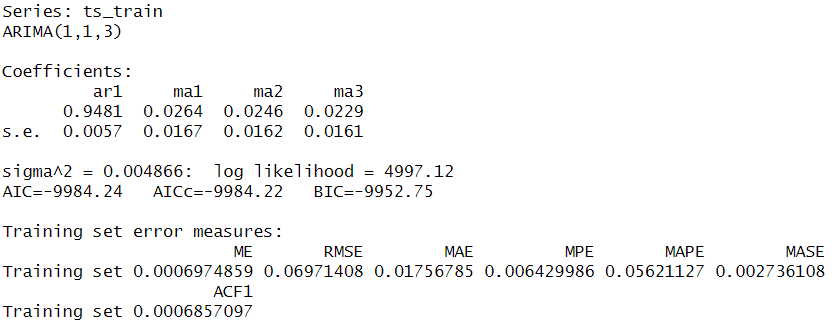

In [57]:
import rpy2.robjects as robjects
# Load the 'forecast' R package
robjects.r("library(forecast)")

# Load the ARIMA model
r_load = robjects.r['readRDS']
aus_wind_arima_model = r_load(r"F:\APU\FYP\SEM 2\Report Doc\R script\aus_wind_arima_model.rds")

R[write to console]: Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: package 'forecast' was built under R version 4.1.3 



In [58]:
# Generate predictions
r_forecast = robjects.r['forecast']
predictions = r_forecast(aus_wind_arima_model, h=len(test))

# Evaluate the model performance
print("Mean Absolute Error: ", mean_absolute_error(predictions.rx('mean')[0], test['Value'].values))
mse = mean_squared_error(predictions.rx('mean')[0], test['Value'].values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ", math.sqrt(mse))

Mean Absolute Error:  11.086975706401342
Mean Squared Error:  177.69998149202146
Root Mean Squared Error:  13.33041565338536


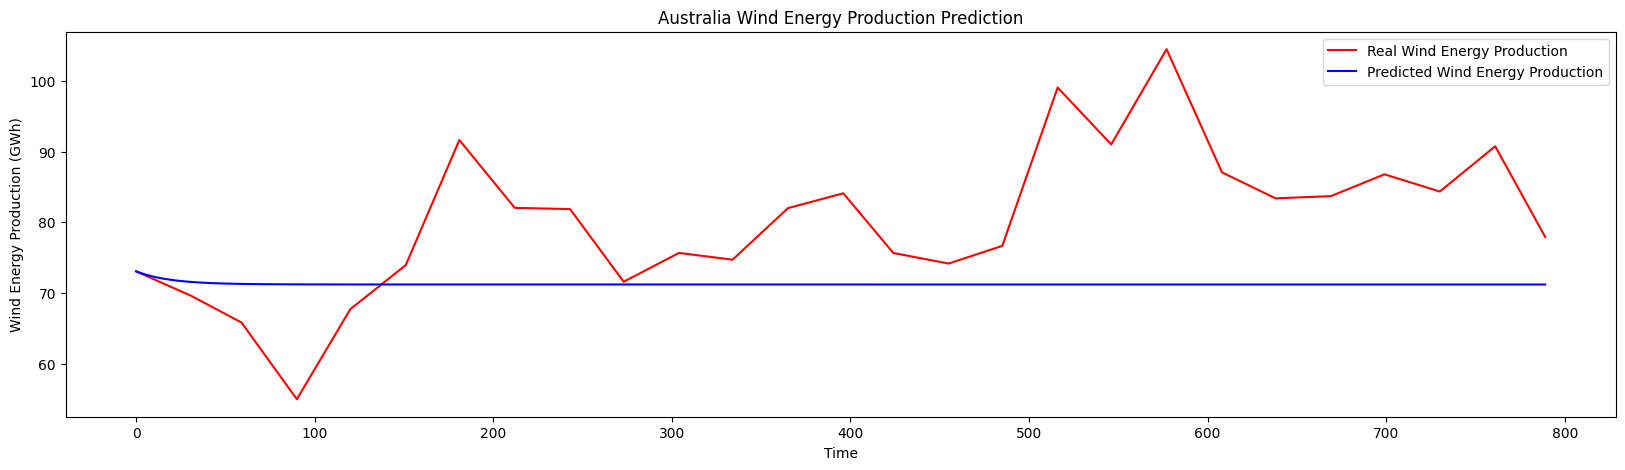

In [59]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test['Value'].values, color = 'red', label = 'Real Wind Energy Production')
plt.plot(predictions.rx('mean')[0], color = 'blue', label = 'Predicted Wind Energy Production')
plt.title('Australia Wind Energy Production Prediction')
plt.xlabel('Time')
plt.ylabel('Wind Energy Production (GWh)')
plt.legend()
plt.show()

## XGBoost - Univariate

In [60]:
def create_features(df, label=None):

    #Creates time series features from datetime index
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week.astype('int64')
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [61]:
X_train, y_train = create_features(train.copy(), label='Value')
X_test, y_test = create_features(test.copy(), label='Value')

print(X_train.head())
print(X_train.shape)
print()
print(y_train.head())
print(y_train.shape)
print()
print(X_test.head())
print(X_test.shape)
print()
print(y_test.head())
print(y_test.shape)

            dayofweek  quarter  month  year  dayofyear  dayofmonth  weekofyear
Date                                                                          
2010-01-01          4        1      1  2010          1           1          53
2010-01-02          5        1      1  2010          2           2          53
2010-01-03          6        1      1  2010          3           3          53
2010-01-04          0        1      1  2010          4           4           1
2010-01-05          1        1      1  2010          5           5           1
(4019, 7)

Date
2010-01-01    13.208677
2010-01-02    13.232129
2010-01-03    13.255581
2010-01-04    13.279032
2010-01-05    13.302484
Freq: D, Name: Value, dtype: float64
(4019,)

            dayofweek  quarter  month  year  dayofyear  dayofmonth  weekofyear
Date                                                                          
2021-01-01          4        1      1  2021          1           1          53
2021-01-02          5       

In [12]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree

In [13]:
aus_daily_xgb = xgb.XGBRegressor(n_estimators=1000)
aus_daily_xgb.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
        verbose=True)

C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:26.43865	validation_1-rmse:62.09426
[1]	validation_0-rmse:18.65458	validation_1-rmse:49.46629
[2]	validation_0-rmse:13.20043	validation_1-rmse:40.72098
[3]	validation_0-rmse:9.40019	validation_1-rmse:34.86011
[4]	validation_0-rmse:6.76504	validation_1-rmse:30.78320
[5]	validation_0-rmse:4.92202	validation_1-rmse:27.97268
[6]	validation_0-rmse:3.67200	validation_1-rmse:26.08183
[7]	validation_0-rmse:2.83465	validation_1-rmse:24.77365
[8]	validation_0-rmse:2.27674	validation_1-rmse:23.84863
[9]	validation_0-rmse:1.89312	validation_1-rmse:23.24519
[10]	validation_0-rmse:1.63648	validation_1-rmse:22.79459
[11]	validation_0-rmse:1.48837	validation_1-rmse:22.49253
[12]	validation_0-rmse:1.39421	validation_1-rmse:22.28295
[13]	validation_0-rmse:1.33949	validation_1-rmse:22.14548
[14]	validation_0-rmse:1.26520	validation_1-rmse:22.05690
[15]	validation_0-rmse:1.12500	validation_1-rmse:21.98603
[16]	validation_0-rmse:1.05603	validation_1-rmse:21.92166
[17]	validation_0-rms

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

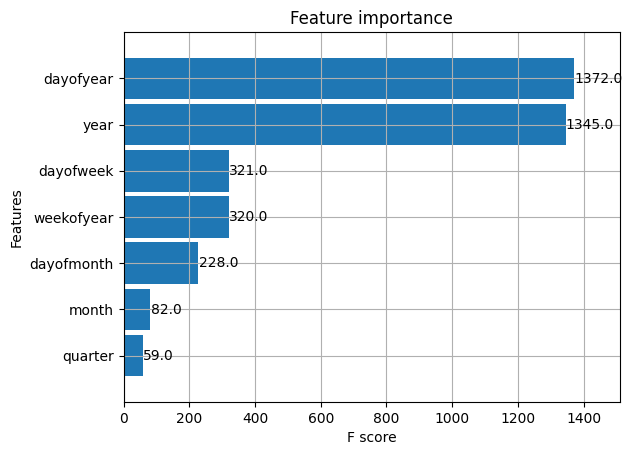

In [14]:
_ = plot_importance(aus_daily_xgb, height=0.9)

In [62]:
xgb_y_pred = aus_daily_xgb.predict(X_test)

In [63]:
print("Mean Absolute Error: ", mean_absolute_error(xgb_y_pred, test['Value'].values))
mse = mean_squared_error(xgb_y_pred, test['Value'].values)
print("Mean Squared Error: ", mse)
import math
print("Root Mean Squared Error: ", math.sqrt(mse))

Mean Absolute Error:  18.1686455622485
Mean Squared Error:  475.81757792356905
Root Mean Squared Error:  21.813243177564612


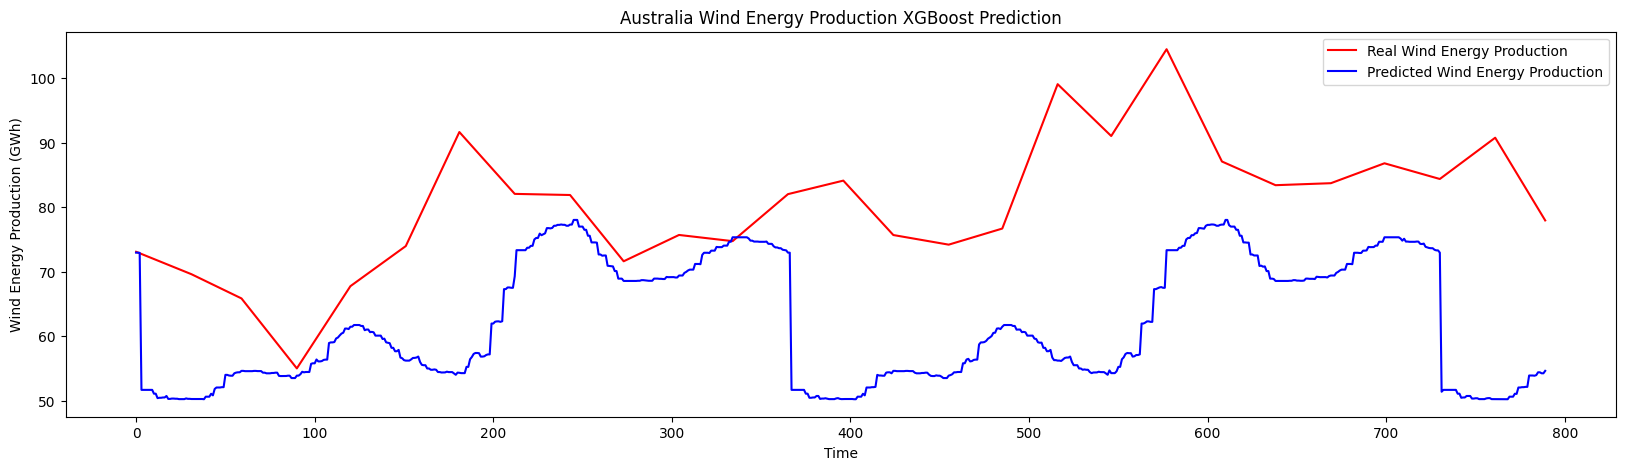

In [64]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test['Value'].values, color = 'red', label = 'Real Wind Energy Production')
plt.plot(xgb_y_pred, color = 'blue', label = 'Predicted Wind Energy Production')
plt.title('Australia Wind Energy Production XGBoost Prediction')
plt.xlabel('Time')
plt.ylabel('Wind Energy Production (GWh)')
plt.legend()
plt.show()

## SVM - Univariate

In [18]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [65]:
# Feature Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[['Value']].values)
test_scaled = scaler.transform(test[['Value']].values)

# Reshape the input data
time_steps = 365  # Define the number of previous time steps to consider

# Creating a data structure with 365 timestamps and 1 output
x_train = []
y_train = []
for i in range(time_steps, len(train)):
    x_train.append(train_scaled[i-time_steps:i, 0])
    y_train.append(train_scaled[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)

print(x_train.shape, y_train.shape)

(3654, 365) (3654,)


In [66]:
# Build and Train the SVM Model
aus_daily_svr = SVR(kernel='linear',gamma=0.5, C=10, epsilon = 0.01) # Specify hyperparameters
aus_daily_svr.fit(x_train, y_train)

SVR(C=10, epsilon=0.01, gamma=0.5, kernel='linear')

In [67]:
dataset_total = pd.concat((train['Value'], test['Value']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 365:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)
x_test = []
for i in range(time_steps, len(test)+time_steps):
    x_test.append(inputs[i-time_steps:i, 0])
x_test = np.array(x_test)

# Predict Wind Energy Production
svr_y_pred = aus_daily_svr.predict(x_test).reshape(-1,1)
svr_y_pred = scaler.inverse_transform(svr_y_pred)
print(svr_y_pred.shape)

(790, 1)


In [68]:
# Evaluate the model
print("Mean Absolute Error: ", mean_absolute_error(svr_y_pred, test['Value'].values))
mse = mean_squared_error(svr_y_pred, test['Value'].values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  0.4788388745383596
Mean Squared Error:  0.31030550870023865
Root Mean Squared Error:  0.5570507236331703


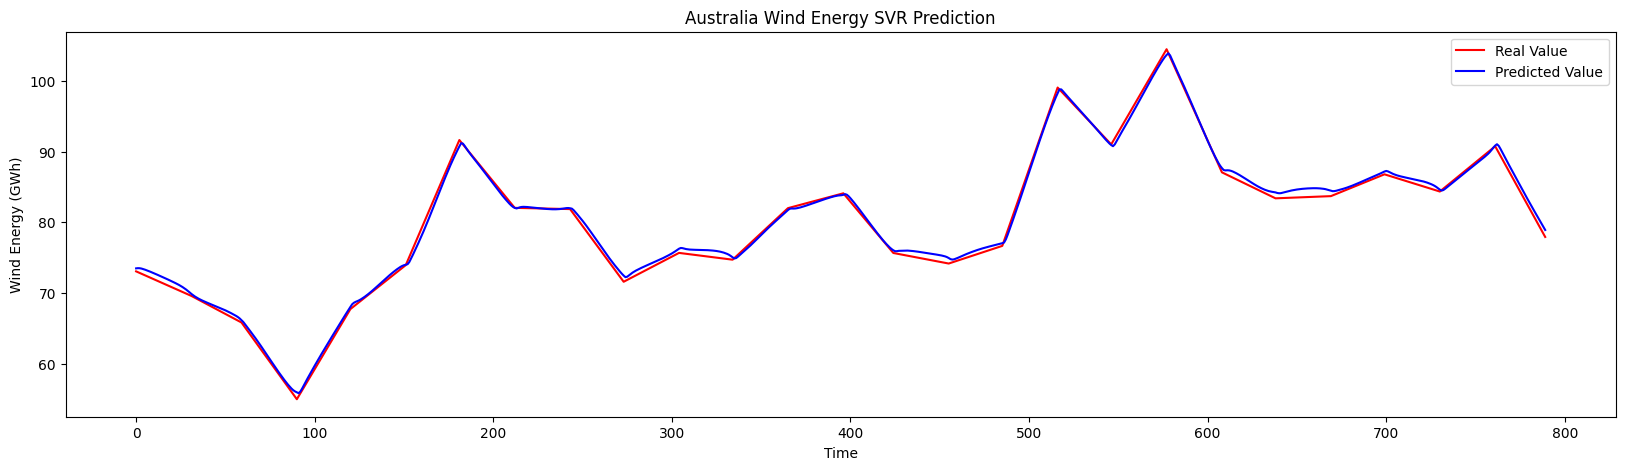

In [69]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test['Value'].values, color='red', label='Real Value')
plt.plot(svr_y_pred, color='blue', label='Predicted Value')
plt.title('Australia Wind Energy SVR Prediction')
plt.xlabel('Time')
plt.ylabel('Wind Energy (GWh)')
plt.legend()
plt.show()

## Univariate GRU - Daily

In [70]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train[['Value']].values)

In [71]:
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

# Set the number of time steps (input sequence length)
time_steps = 365

# Create the training datasets
X_train, y_train = create_dataset(training_set_scaled, time_steps)

# Create the testing datasets
X_test, y_test = create_dataset(test['Value'].values, time_steps)

In [26]:
from keras.models import Sequential
from keras.layers import GRU, Dense

# Create the model
aus_daily_gru = Sequential()
aus_daily_gru.add(GRU(units=64, return_sequences=True, input_shape=(time_steps, 1)))
aus_daily_gru.add(GRU(units=64, input_shape=(time_steps, 1)))
aus_daily_gru.add(Dense(1, activation='linear'))

aus_daily_gru.compile(optimizer='adam', loss='mean_squared_error')

In [27]:
aus_daily_gru.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
115/115 [==============================] - 102s 574ms/step - loss: 0.0096
Epoch 2/100
115/115 [==============================] - 64s 560ms/step - loss: 1.0399e-04
Epoch 3/100
115/115 [==============================] - 66s 578ms/step - loss: 8.2768e-05
Epoch 4/100
115/115 [==============================] - 66s 573ms/step - loss: 6.8508e-05
Epoch 5/100
115/115 [==============================] - 65s 567ms/step - loss: 5.5432e-05
Epoch 6/100
115/115 [==============================] - 69s 603ms/step - loss: 4.6933e-05
Epoch 7/100
115/115 [==============================] - 67s 584ms/step - loss: 4.0679e-05
Epoch 8/100
115/115 [==============================] - 64s 556ms/step - loss: 3.7379e-05
Epoch 9/100
115/115 [==============================] - 68s 593ms/step - loss: 3.0563e-05
Epoch 10/100
115/115 [==============================] - 69s 599ms/step - loss: 2.5605e-05
Epoch 11/100
115/115 [==============================] - 64s 553ms/step - loss: 2.1645e-05
Epoch 12/100
115/115 [

In [79]:
# Getting the predicted value
dataset_total = pd.concat((train['Value'], test['Value']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 365:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(time_steps, len(test)+time_steps):
    X_test.append(inputs[i-time_steps:i, 0])
X_test = np.array(X_test)

gru_y_pred = aus_daily_gru.predict(X_test)
gru_y_pred = sc.inverse_transform(gru_y_pred)

25/25 [==============================] - 17s 88ms/step


In [80]:
print("Mean Absolute Error: ", mean_absolute_error(gru_y_pred, test['Value'].values))
mse = mean_squared_error(gru_y_pred, test['Value'].values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  0.10872506111928905
Mean Squared Error:  0.0224748232425134
Root Mean Squared Error:  0.1499160539852667


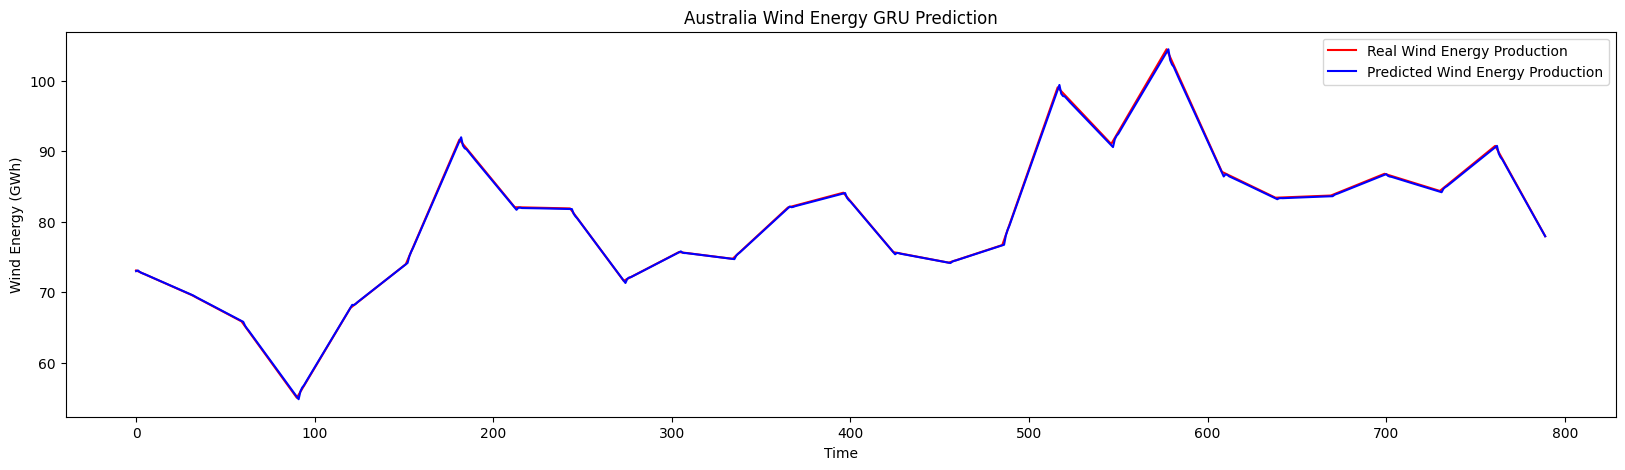

In [81]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test['Value'].values, color = 'red', label = 'Real Wind Energy Production')
plt.plot(gru_y_pred, color = 'blue', label = 'Predicted Wind Energy Production')
plt.title('Australia Wind Energy GRU Prediction')
plt.xlabel('Time')
plt.ylabel('Wind Energy (GWh)')
plt.legend()
plt.show()

## Univariate LSTM - Daily

In [31]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train[['Value']].values)

print(training_set_scaled)
print(training_set_scaled.shape)

[[0.05229899]
 [0.05263655]
 [0.05297411]
 ...
 [0.91703502]
 [0.9155022 ]
 [0.91396938]]
(4019, 1)


In [32]:
# Creating a data structure with 365 timestamps and 1 output
X_train = []
y_train = []
for i in range(time_steps, len(train)):
    X_train.append(training_set_scaled[i-time_steps:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [33]:
print(X_train)
X_train.shape

[[0.05229899 0.05263655 0.05297411 ... 0.06917153 0.06724314 0.06531475]
 [0.05263655 0.05297411 0.05331167 ... 0.06724314 0.06531475 0.06338636]
 [0.05297411 0.05331167 0.05364922 ... 0.06531475 0.06338636 0.06582278]
 ...
 [0.62567426 0.62363574 0.6216205  ... 0.92163348 0.92010066 0.91856784]
 [0.62363574 0.6216205  0.61960525 ... 0.92010066 0.91856784 0.91703502]
 [0.6216205  0.61960525 0.61759001 ... 0.91856784 0.91703502 0.9155022 ]]


(3654, 365)

In [34]:
print(y_train)
y_train.shape

[0.06338636 0.06582278 0.06825921 ... 0.91703502 0.9155022  0.91396938]


(3654,)

In [35]:
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [36]:
# Building the RNN

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [37]:
# Initialising the RNN
aus_daily_uni_lstm = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
aus_daily_uni_lstm.add(LSTM(units = 64, return_sequences = True, input_shape = (X_train.shape[1], 1)))
aus_daily_uni_lstm.add(Dropout(0.2))

aus_daily_uni_lstm.add(LSTM(units = 64, return_sequences = True))
aus_daily_uni_lstm.add(Dropout(0.2))

aus_daily_uni_lstm.add(LSTM(units = 64))
aus_daily_uni_lstm.add(Dropout(0.2))

# Adding the output layer
aus_daily_uni_lstm.add(Dense(units = 1))

In [38]:
# Compiling the RNN
aus_daily_uni_lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
aus_daily_uni_lstm.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
115/115 [==============================] - 222s 850ms/step - loss: 0.0078
Epoch 2/100
115/115 [==============================] - 99s 857ms/step - loss: 0.0023
Epoch 3/100
115/115 [==============================] - 105s 910ms/step - loss: 0.0020
Epoch 4/100
115/115 [==============================] - 111s 966ms/step - loss: 0.0017
Epoch 5/100
115/115 [==============================] - 110s 953ms/step - loss: 0.0014
Epoch 6/100
115/115 [==============================] - 115s 1s/step - loss: 0.0014
Epoch 7/100
115/115 [==============================] - 111s 965ms/step - loss: 0.0012
Epoch 8/100
115/115 [==============================] - 108s 938ms/step - loss: 0.0011
Epoch 9/100
115/115 [==============================] - 101s 876ms/step - loss: 0.0011
Epoch 10/100
115/115 [==============================] - 88s 767ms/step - loss: 0.0010
Epoch 11/100
115/115 [==============================] - 97s 846ms/step - loss: 0.0010
Epoch 12/100
115/115 [==============================] - 10

115/115 [==============================] - 43s 378ms/step - loss: 3.0134e-04
Epoch 93/100
115/115 [==============================] - 45s 393ms/step - loss: 3.5729e-04
Epoch 94/100
115/115 [==============================] - 47s 408ms/step - loss: 3.0413e-04
Epoch 95/100
115/115 [==============================] - 49s 424ms/step - loss: 3.1006e-04
Epoch 96/100
115/115 [==============================] - 45s 394ms/step - loss: 3.7815e-04
Epoch 97/100
115/115 [==============================] - 45s 393ms/step - loss: 3.4102e-04
Epoch 98/100
115/115 [==============================] - 45s 393ms/step - loss: 2.8162e-04
Epoch 99/100
115/115 [==============================] - 46s 397ms/step - loss: 3.3433e-04
Epoch 100/100
115/115 [==============================] - 46s 396ms/step - loss: 3.4170e-04


In [39]:
test[['Value']].shape

(790, 1)

In [82]:
# Getting the predicted stock price of 2017
dataset_total = pd.concat((train['Value'], test['Value']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 365:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
y_test = []
for i in range(time_steps, len(test)+time_steps):
    X_test.append(inputs[i-time_steps:i, 0])
    y_test.append(inputs[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
uni_lstm_y_pred = aus_daily_uni_lstm.predict(X_test)
uni_lstm_y_pred = sc.inverse_transform(uni_lstm_y_pred)

25/25 [==============================] - 19s 146ms/step


In [83]:
print("Mean Absolute Error: ", mean_absolute_error(uni_lstm_y_pred, test['Value'].values))
mse = mean_squared_error(uni_lstm_y_pred, test['Value'].values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  1.2049680874708206
Mean Squared Error:  2.5422264020329544
Root Mean Squared Error:  1.5944360764963124


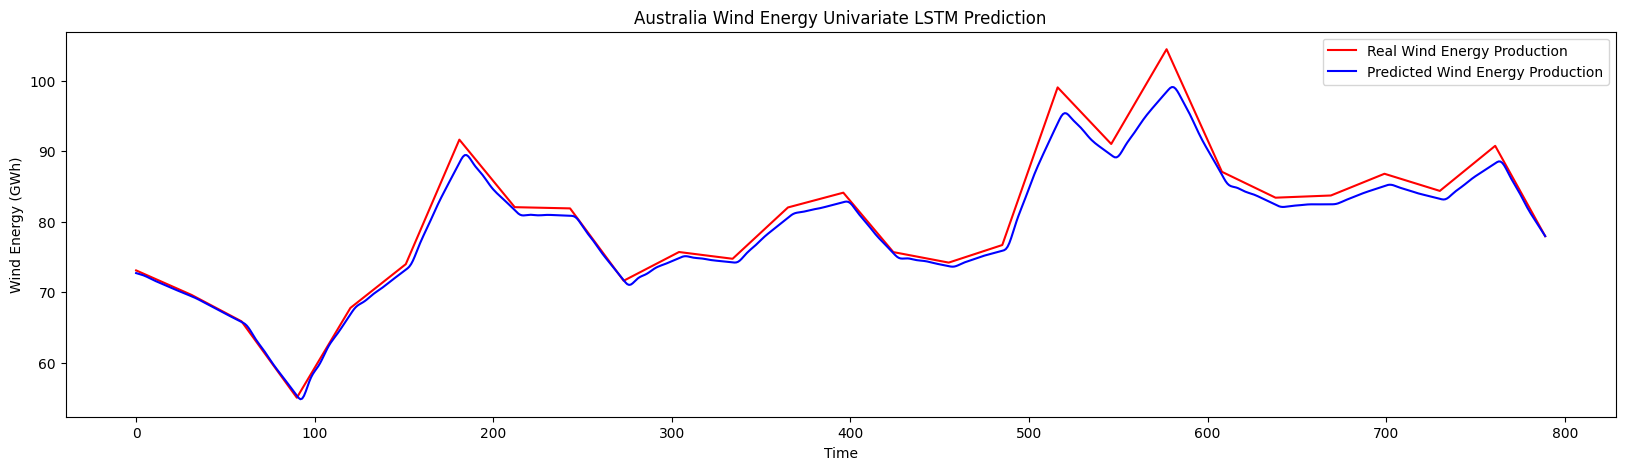

In [84]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test['Value'].values, color = 'red', label = 'Real Wind Energy Production')
plt.plot(uni_lstm_y_pred, color = 'blue', label = 'Predicted Wind Energy Production')
plt.title('Australia Wind Energy Univariate LSTM Prediction')
plt.xlabel('Time')
plt.ylabel('Wind Energy (GWh)')
plt.legend()
plt.show()

## Multivariate LSTM

In [85]:
data = wind_production_data['Australia']

data.shape

(4808, 3)

In [86]:
X = data[['Wind10int', 'Wind100int', 'Value']]
y = data[['Value']]

X.head()

,Wind10int,Wind100int,Value
Date,,,
2010-01-01,4.252949,6.221607,13.208677
2010-01-02,4.245952,6.212901,13.232129
2010-01-03,4.238954,6.204195,13.255581
2010-01-04,4.231957,6.195489,13.279032
2010-01-05,4.224960,6.186783,13.302484


In [87]:
# Split the data into training and testing sets
split_date = '2021-01-01'
X_train, X_test = X[:split_date], X[split_date:]
y_train, y_test = y[:split_date], y[split_date:]

In [88]:
# Scale the features and target variables using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
X_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))
X_train, X_test = X_scaler.fit_transform(X_train), X_scaler.transform(X_test)
y_train, y_test = y_scaler.fit_transform(y_train), y_scaler.transform(y_test)

In [89]:
print(X_train.shape)
print(X_test.shape)
print()
print(y_train.shape)
print(y_test.shape)

(4019, 3)
(790, 3)

(4019, 1)
(790, 1)


In [90]:
# Reshape the input data to fit the LSTM model (samples, time steps, features)
time_steps = 365  # Define the number of previous time steps to consider
n_features = X_train.shape[1]  # Number of features

# Creating a data structure with 365 timestamps and 1 output
X_train1 = []
y_train1 = []
for i in range(time_steps, len(X_train)):
    X_train1.append(X_train[i-time_steps:i])
    y_train1.append(y_train[i][0])
X_train1, y_train1 = np.array(X_train1), np.array(y_train1)

print(X_train1.shape)

(3654, 365, 3)


In [91]:
X_train1 = np.reshape(X_train1, (X_train1.shape[0], X_train1.shape[1], X_train1.shape[2]))

In [50]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

aus_daily_multi_lstm = Sequential()
aus_daily_multi_lstm.add(LSTM(units = 64, return_sequences = True, input_shape=(time_steps, n_features)))
aus_daily_multi_lstm.add(Dropout(0.2))
aus_daily_multi_lstm.add(LSTM(units = 64, activation = 'relu', return_sequences = True))
aus_daily_multi_lstm.add(Dropout(0.2))
aus_daily_multi_lstm.add(LSTM(units = 64))
aus_daily_multi_lstm.add(Dropout(0.2))
aus_daily_multi_lstm.add(Dense(1))

In [51]:
aus_daily_multi_lstm.compile(optimizer='adam', loss='mean_squared_error')

aus_daily_multi_lstm.fit(X_train1, y_train1, epochs=100, batch_size=32)

Epoch 1/100
115/115 [==============================] - 122s 367ms/step - loss: 0.0110
Epoch 2/100
115/115 [==============================] - 33s 286ms/step - loss: 0.0029
Epoch 3/100
115/115 [==============================] - 33s 289ms/step - loss: 0.0023
Epoch 4/100
115/115 [==============================] - 33s 287ms/step - loss: 0.0020
Epoch 5/100
115/115 [==============================] - 33s 288ms/step - loss: 0.0018
Epoch 6/100
115/115 [==============================] - 34s 292ms/step - loss: 0.0016
Epoch 7/100
115/115 [==============================] - 33s 284ms/step - loss: 0.0015
Epoch 8/100
115/115 [==============================] - 32s 282ms/step - loss: 0.0014
Epoch 9/100
115/115 [==============================] - 32s 282ms/step - loss: 0.0013
Epoch 10/100
115/115 [==============================] - 33s 290ms/step - loss: 0.0013
Epoch 11/100
115/115 [==============================] - 34s 295ms/step - loss: 0.0011
Epoch 12/100
115/115 [==============================] - 32s 28

In [92]:
X_total_data = X
inputs = X_total_data[len(X_total_data) - len(X_test) - 365:]
inputs = X_scaler.transform(inputs)
print(inputs.shape)
len(X_test)
X_test1 = []
for i in range(time_steps, len(X_test)+time_steps):
    X_test1.append(inputs[i-time_steps:i])
X_test1 = np.array(X_test1)
X_test1 = np.reshape(X_test1, (X_test1.shape[0], X_test1.shape[1], X_test1.shape[2]))
multi_lstm_y_pred = aus_daily_multi_lstm.predict(X_test1)
multi_lstm_y_pred = y_scaler.inverse_transform(multi_lstm_y_pred)
real_value = y_scaler.inverse_transform(y_test)
hist_value = y_scaler.inverse_transform(y_train)
multi_lstm_y_pred

(1155, 3)
25/25 [==============================] - 19s 156ms/step


array([[73.634544],
       [73.56649 ],
       [73.49263 ],
       [73.40982 ],
       [73.318085],
       [73.219   ],
       [73.11432 ],
       [73.0052  ],
       [72.892044],
       [72.77476 ],
       [72.65311 ],
       [72.527054],
       [72.39699 ],
       [72.263695],
       [72.1283  ],
       [71.9921  ],
       [71.856384],
       [71.722244],
       [71.590614],
       [71.462135],
       [71.3372  ],
       [71.215996],
       [71.098564],
       [70.98477 ],
       [70.87444 ],
       [70.76726 ],
       [70.66284 ],
       [70.56077 ],
       [70.46053 ],
       [70.361595],
       [70.263405],
       [70.165375],
       [70.06698 ],
       [69.96575 ],
       [69.85872 ],
       [69.74381 ],
       [69.620445],
       [69.48934 ],
       [69.351974],
       [69.21009 ],
       [69.06512 ],
       [68.91803 ],
       [68.76931 ],
       [68.61902 ],
       [68.46708 ],
       [68.313416],
       [68.158104],
       [68.001396],
       [67.843735],
       [67.685646],


In [93]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print("Mean Absolute Error: ", mean_absolute_error(multi_lstm_y_pred, real_value))
mse = mean_squared_error(multi_lstm_y_pred, real_value)
print("Mean Squared Error: ", mse)
import math
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  5.012767698353326
Mean Squared Error:  82.53419451731423
Root Mean Squared Error:  9.08483321351109


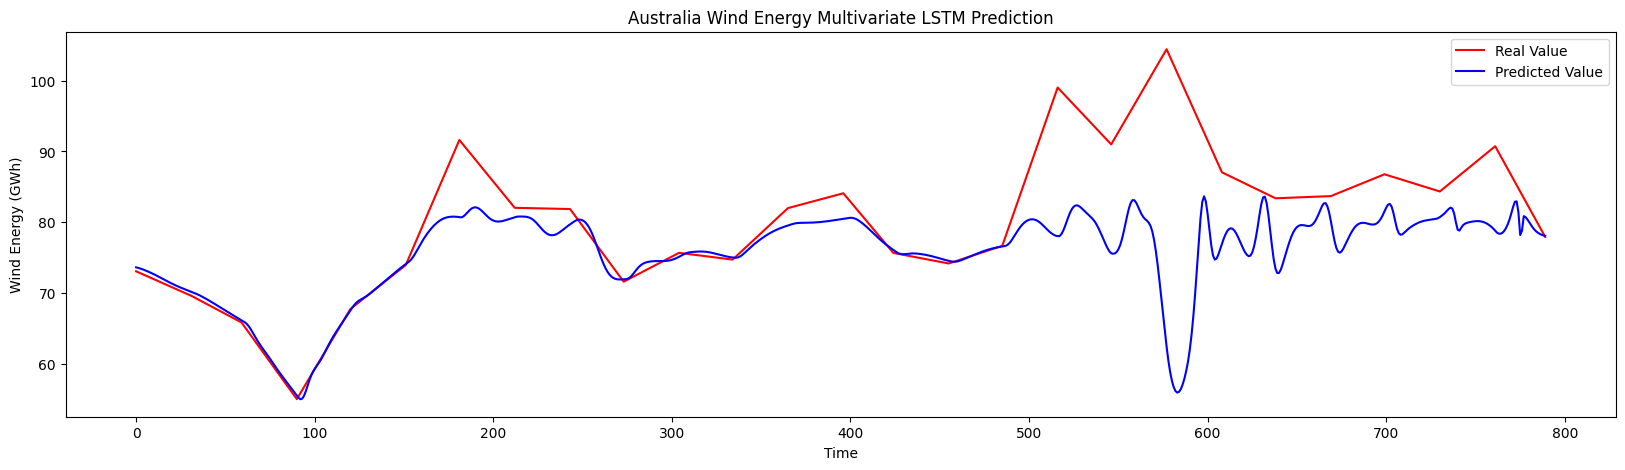

In [94]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(real_value, color='red', label='Real Value')
plt.plot(multi_lstm_y_pred, color='blue', label='Predicted Value')
plt.title('Australia Wind Energy Multivariate LSTM Prediction')
plt.xlabel('Time')
plt.ylabel('Wind Energy (GWh)')
plt.legend()
plt.show()

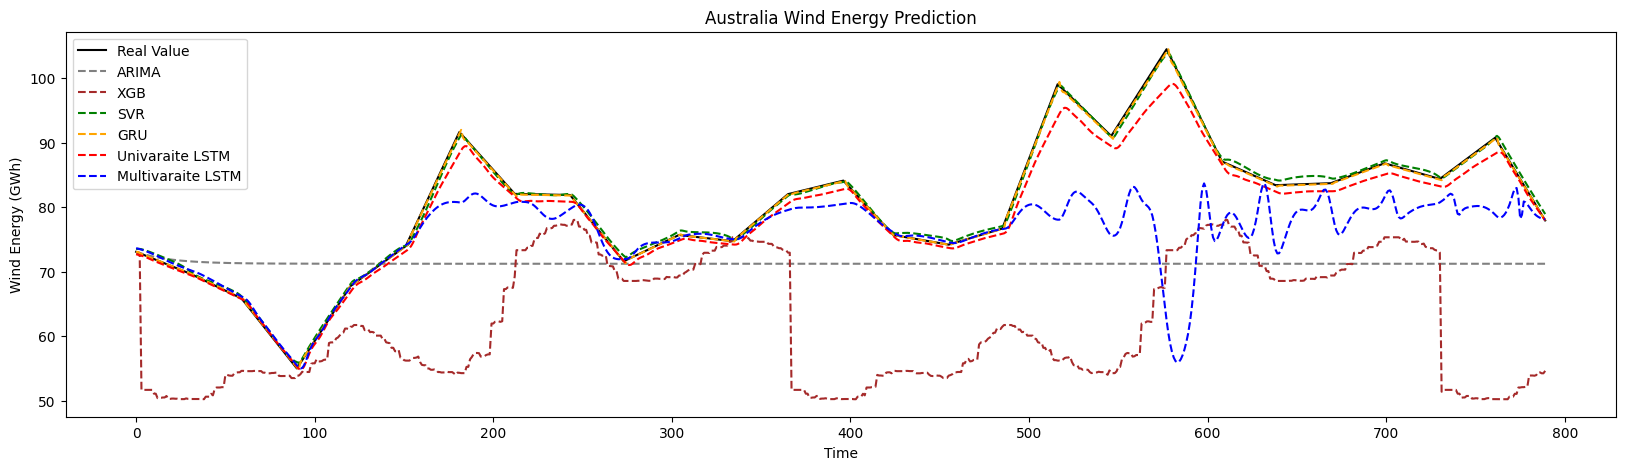

In [96]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(real_value, color='black', label='Real Value')
plt.plot(predictions.rx('mean')[0], color='grey', linestyle='--', label='ARIMA')
plt.plot(xgb_y_pred, color='brown', linestyle='--', label='XGB')
plt.plot(svr_y_pred, color='green', linestyle='--', label='SVR')
plt.plot(gru_y_pred, color='orange', linestyle='--', label='GRU')
plt.plot(uni_lstm_y_pred, color='red', linestyle='--', label='Univaraite LSTM')
plt.plot(multi_lstm_y_pred, color='blue', linestyle='--', label='Multivaraite LSTM')
plt.title('Australia Wind Energy Prediction')
plt.xlabel('Time')
plt.ylabel('Wind Energy (GWh)')
plt.legend()
plt.show()

# Save Best Model

In [56]:
aus_daily_gru.save("aus_wind_best_gru.h5")

C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
